# ShearLineCNN
> Shear Line Classification using CNN.

## Revision History

| #   | Date       | Action                                           | Modified by        |
|-----|------------|--------------------------------------------------|--------------------|
|     |            |                                                  |                    |
| 004 | 2025-04-10 | Fix architecture to match dataset                | rmaniego           |
| 003 | 2025-04-10 | Update architecture base codes                   | rmaniego           |
| 002 | 2025-04-09 | Prepare dataset                                  | rmaniego           |
| 001 | 2025-03-29 | Create GitHub repository                         | rmaniego           |

## Step 1. Mount Google Drive

**Notes:**.
 - This requires GDrive permissions.
 - Update changes in local repository.
 - Re-run cell for every commit changes in the repository.
 - Colab is read only, unless set in GitHub FGPATs

```python
pip install jupyterlab
pip install notebook
jupyter notebook
```

**GitHub Personal Access Tokens (PAT)**
1. Go to `https://github.com/settings/tokens`.
2. On the sidebar, select `Fine-grained tokens`.
3. Fill-up appropriate details, limit read/write access.
4. Copy generated `PAT` to local environment variables.
5. Do the same to Google Colab secrets.
6. Once expired, move the old repo in GDrive to trash.

In [1]:
import os

github_fgpat = None
live_on_colab = False
environment_ready = False

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

try:
    from google.colab import drive, userdata

    drive.mount("/content/drive")

    github_fgpat = userdata.get("SLCNN")
    live_on_colab = True
except ImportError:
    pass # github_fgpat = os.environ.get("SLCNN")

## Step 2. Check Colab Compute Engine Backend 
**Note:** Execute to verify HW accelerator allocation, use information on manuscript.

HW accelerator availability may vary, so ensure that the session is timed and is connected to expected runtime environment in all iterations. Options include:
1. NVIDIA A100 Tensor Core GPU - high-performance deep learning training (recommended).
2. NVIDIA L4 Tensor Core GPU - optimized for AI inference tasks with high performance and efficiency (preferred during HP fine-tuning).
3. NVIDIA T4 Tensor Core GPU - cost-effective, versatile, and suitable for a variety of tasks.


In [2]:
if live_on_colab:
    gpu_info = !nvidia-smi
    gpu_info = "\n".join(gpu_info)
    if gpu_info.find("failed") >= 0:
        print("Not connected to a GPU")
    else:
        print(gpu_info)

    from psutil import virtual_memory

    ram_gb = virtual_memory().total / 1e9
    print(f"Your runtime has {ram_gb:.1f} gigabytes of available RAM")

    if ram_gb < 20:
        print("Not using a high-RAM runtime")
    else:
        print("You are using a high-RAM runtime!")

## Step 3. Change Working Directory
**Note:** Execute cell to ensure the notebook is running under the latest version of project repository.

In [3]:
if live_on_colab:
    NB = "/content/drive/MyDrive/Colab Notebooks/"
    os.makedirs(NB, exist_ok=True)
    
    def update_repo():
    
        REPO = f"{NB}/ShearLineCNN"
        if not os.path.isdir(REPO):
            os.chdir(NB)
            !git clone https://{github_fgpat}@github.com/rmaniego/ShearLineCNN.git
            return
    
        os.chdir(REPO)
        !git reset --hard HEAD
        !git pull origin main
    
    update_repo()

print(os.getcwd())

C:\drive\notebooks\work\vsu-dcst\03 RDE\24 1111 Parages ShearLine CNN (BSMet)\ShearLineCNN


## Step 4. Install Dependencies
**Note:** Execute cell everytime the `Google Colab` runtime environment reconnected.

In [4]:
if live_on_colab:
    %pip install -U jupyterlab
    %pip install -U notebook
    %pip install -U opencv-python 
    %pip install -U scikit-learn
    %pip install -U scikit-image
    %pip install -U matplotlib
    %pip install -U seaborn
    %pip install -U tensorflow
    %pip install -U tabulate
    print("Environment is ready...")

## Step 5: Import the Packages  

import all third party libraries necessary for the ANN model to execute successfully.

In [29]:
import glob
import json
import time
import warnings
from datetime import datetime

warnings.filterwarnings("ignore", category=RuntimeWarning, message="os.fork()")

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Cropping2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adadelta

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    print("GPU detected. Running on GPU.")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
            print(e)
else:
    print("No GPU detected. Running on CPU.")

No GPU detected. Running on CPU.


## Step 6: Load Datasets  

Load and prepare the training and testing datasets.

In [8]:
def load_features(source, target, category):
    basenames, features, labels = [], [], []

    sources = glob.glob(f"{source}/{category}/*.json")
    for source_path in sources:
        filename = os.path.basename(source_path)
        print(filename)

        with open(source_path, "r", encoding="utf-8") as file:
            data1 = np.array(json.load(file))

        target_path = f"{target}/{category}/{filename}"
        with open(target_path, "r", encoding="utf-8") as file:
            data2 = np.array(json.load(file))

        features.append(data1)
        labels.append(data2)
        basenames.append(filename)

        # remove this break block in actual execution
        if len(basenames) > 5:
            break

    return basenames, np.array(features), np.array(labels)

# Prepare dataset
basenames_list, features_list, labels_list = [], [], []

categories = ["no-shear", "shear"]
for category in categories:
    basenames, features, labels = load_features("data/source", "data/target", category)
    if features.size > 0:
        basenames_list.extend(basenames)
        features_list.append(features)
        labels_list.append(labels)

features = np.vstack(features_list)
labels = np.vstack(labels_list)
basenames = np.array(basenames_list)

# 90:10 split for testing (only split basenames)
basenames_train_val, basenames_test = train_test_split(
    basenames, test_size=0.1, shuffle=True
)

mask_train_val = [name in basenames_train_val for name in basenames]
features_train_val = features[mask_train_val]
labels_train_val = labels[mask_train_val]

# Now, split features and labels based on the new splits
mask_test = [name in basenames_test for name in basenames]
features_test = features[mask_test]
labels_test = labels[mask_test]

# 80:20 split for train-validation
basenames_train, basenames_val = train_test_split(
    basenames_train_val, test_size=0.2, shuffle=True
)
mask_train = [name in basenames_train for name in basenames_train_val]
features_train = features_train_val[mask_train]
labels_train = labels_train_val[mask_train]

# Split features and labels based on the new train-val split
mask_val = [name in basenames_val for name in basenames_train_val]
features_val = features_train_val[mask_val]
labels_val = labels_train_val[mask_val]

print("Dataset ready...")

2010-01-08.json
2010-01-09.json
2010-01-21.json
2010-02-20.json
2010-03-02.json
2010-03-22.json
2010-01-01.json
2010-01-02.json
2010-01-04.json
2010-01-05.json
2010-01-13.json
2010-01-14.json
Dataset ready...


## Step 7: Define the Architecture  

Define the structure of the convolutional neural network for shear line classification. 

In [33]:
model = Sequential()

model.add(Input(shape=(161, 141, 2)))

model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.01))

model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.01))

model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.01))

model.add(UpSampling2D(size=(2, 2)))
model.add(UpSampling2D(size=(2, 2)))
model.add(UpSampling2D(size=(2, 2)))

model.add(Cropping2D(cropping=((1, 6), (1, 2))))

model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.01))

model.add(Conv2D(1, (3, 3), activation="sigmoid", padding="same"))

optimizer = Adadelta(learning_rate=1.0, rho=0.95)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_81 (Conv2D)                   │ (None, 161, 141, 32)        │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_51 (MaxPooling2D)      │ (None, 81, 71, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 81, 71, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 81, 71, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_82 (Conv2D)                   │ (None, 81, 71, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 41, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 41, 36, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 41, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_83 (Conv2D)                   │ (None, 41, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 21, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 21, 18, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 21, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_32 (UpSampling2D)      │ (None, 42, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_33 (UpSampling2D)      │ (None, 84, 72, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_34 (UpSampling2D)      │ (None, 168, 144, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d_7 (Cropping2D)            │ (None, 161, 141, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_84 (Conv2D)                   │ (None, 161, 141, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 161, 141, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 161, 141, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 168,481 (658.13 KB)

 Trainable params: 167,905 (655.88 KB)

 Non-trainable params: 576 (2.25 KB)

## Step 8: Train the Model  

Feed the training-val dataset to the compiled CNN model.

In [34]:
warnings.filterwarnings("ignore", category=UserWarning, message="warn")

EPOCHS = 10          # Increase to 500/1000 epochs in actual run
BATCH_SIZE = 4       # Increase to 32 epochs in actual run
ARCHITECTURE = "CNN"

MODELS = "models"
ANALYSIS = "analysis"
DATASET = "data"
TEST = "test"

os.makedirs(MODELS, exist_ok=True)
os.makedirs(ANALYSIS, exist_ok=True)

training_timestamp = int(time.time())

history = model.fit(
    features_train,
    labels_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(features_val, labels_val),
    # callbacks=[early_stopping, scheduler]
)

training_duration = (int(time.time()) - training_timestamp) / 1000 / 60

print(f"Training completed in {training_duration:.2f} minutes.")

fullpath = f"{MODELS}/shearline.{ARCHITECTURE}_{training_timestamp}.keras"
model.save(fullpath)

with open(f"{ANALYSIS}/metrics_{training_timestamp}.json", "w") as f:
    json.dump({
        "loss": history.history["loss"],
        "accuracy": history.history["accuracy"],
        "val_loss": history.history["val_loss"],
        "val_accuracy": history.history["val_accuracy"]
    }, f, indent=4)

print(f"Model training complete and saved to '{fullpath}'")
print(f"Training and validation metrics saved to '{ANALYSIS}/metrics_{training_timestamp}.json'")

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5151 - loss: 1.1623 - val_accuracy: 0.4999 - val_loss: 0.8579
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 867ms/step - accuracy: 0.5117 - loss: 0.8909 - val_accuracy: 0.3741 - val_loss: 1.2782
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 870ms/step - accuracy: 0.5781 - loss: 0.7805 - val_accuracy: 0.1368 - val_loss: 1.4600
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 846ms/step - accuracy: 0.6130 - loss: 0.7081 - val_accuracy: 0.4210 - val_loss: 0.9224
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 833ms/step - accuracy: 0.6467 - loss: 0.6587 - val_accuracy: 0.2786 - val_loss: 0.9068
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 860ms/step - accuracy: 0.6402 - loss: 0.6595 - val_accuracy: 0.3847 - val_loss: 0.8914
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 866ms/step - accuracy: 0.7171 - loss: 0.6389 - val_accuracy: 0.6007 - val_loss: 0.7755
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 856ms/step - accuracy: 0.7770 - loss: 0.6141 - val_accuracy: 0.7732 - val_loss: 0.

## Step 9: Generate Training Analysis  

**Metrics Definitions**
* Loss is computed based on how far each prediction is from the ground truth, specifically using Binary Cross-entropy.
* Accuracy is the proportion of correct predictions to the total predictions.  

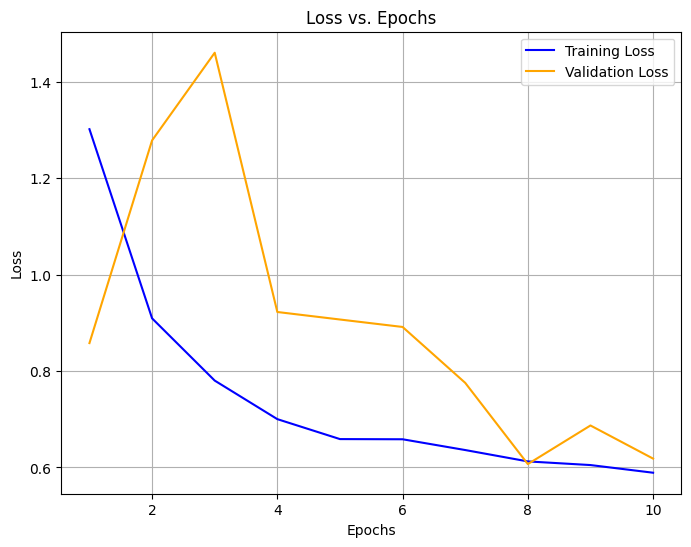

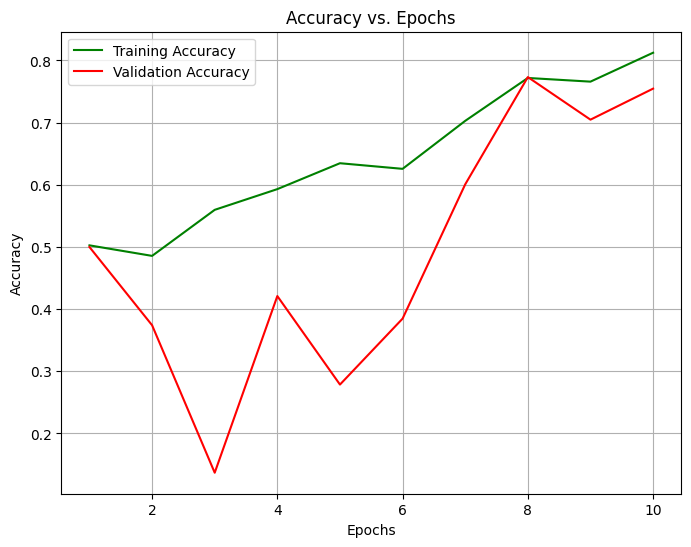


Plots saved to analysis


In [35]:
import seaborn as sns
import matplotlib.pyplot as plt


with open(f"{ANALYSIS}/metrics_{training_timestamp}.json", "r") as f:
    metrics = json.load(f)

epochs = range(1, len(metrics["loss"]) + 1)

plt.figure(figsize=(8, 6))
sns.lineplot(x=epochs, y=metrics["loss"], label="Training Loss", color="blue")
sns.lineplot(x=epochs, y=metrics["val_loss"], label="Validation Loss", color="orange")
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig(f"{ANALYSIS}/loss_plot_{training_timestamp}.png")
plt.show()

plt.figure(figsize=(8, 6))
sns.lineplot(x=epochs, y=metrics["accuracy"], label="Training Accuracy", color="green")
sns.lineplot(x=epochs, y=metrics["val_accuracy"], label="Validation Accuracy", color="red")
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.savefig(f"{ANALYSIS}/accuracy_plot_{training_timestamp}.png")
plt.show()

print(f"\nPlots saved to {ANALYSIS}")

## Step 10: Test the Model

In [42]:
start_time = time.time()
results = model.predict(features_test, verbose=1)
prediction_duration = time.time() - start_time
image_prediction_time = prediction_duration / len(features_test)

predictions = (results > 0.5).astype("int32")
predictions_flat = predictions.flatten()
labels_test_flat = labels_test.flatten()

print(f"Total prediction time: {prediction_duration:.4f} seconds")
print(f"Time per image: {image_prediction_time:.4f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
Total prediction time: 0.7734 seconds
Time per image: 0.3867 seconds


## Step 11: Display the Results

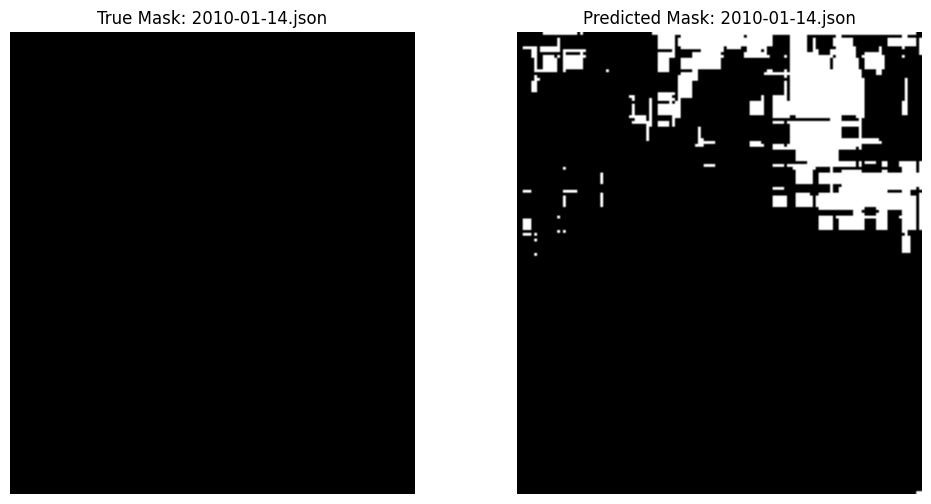

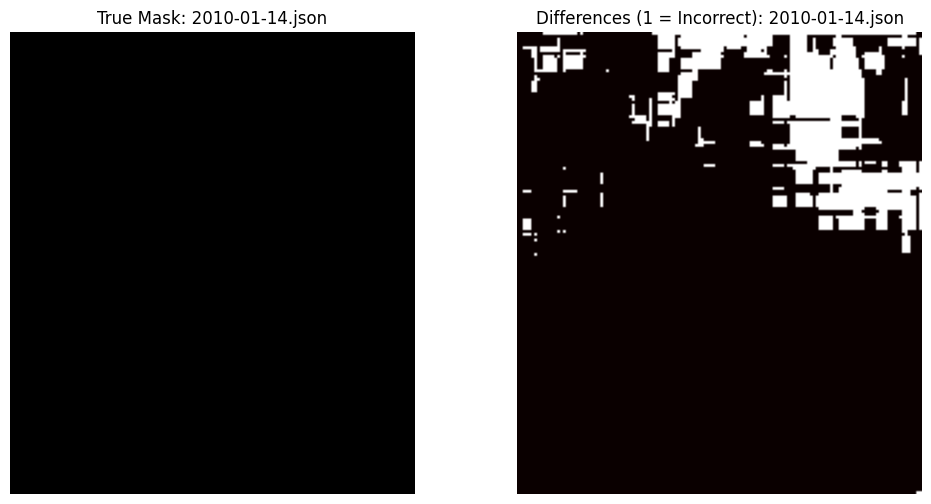

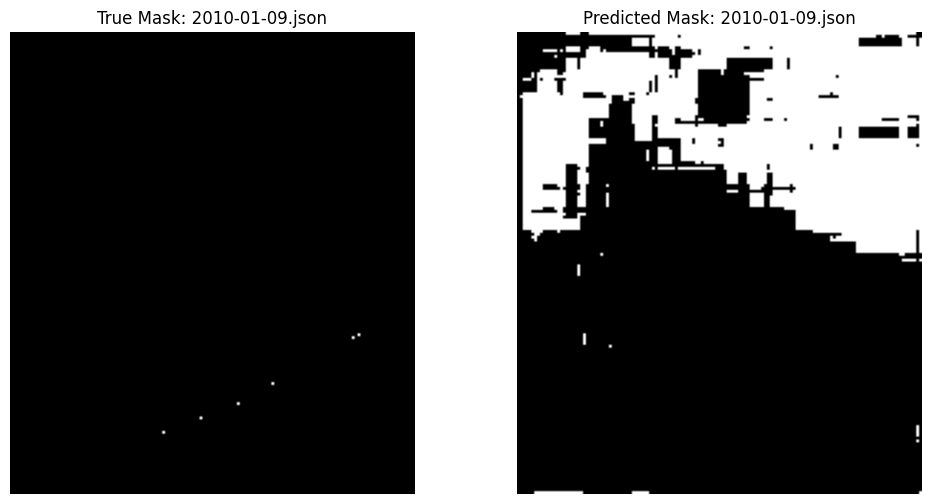

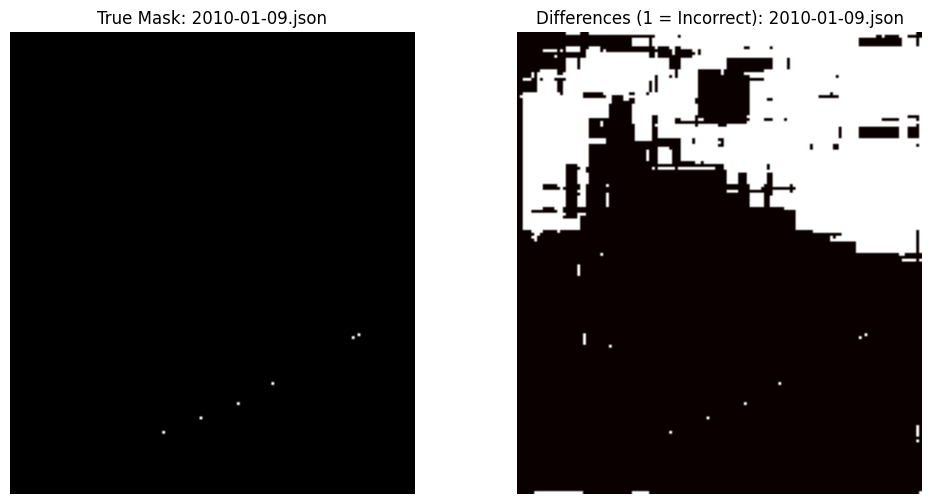

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

def visualize_comparison(true_mask, predicted_mask, filename):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(true_mask, cmap="gray")
    plt.title(f"True Mask: {filename}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap="gray")
    plt.title(f"Predicted Mask: {filename}")
    plt.axis("off")

    plt.show()

def visualize_diff(true_mask, predicted_mask, filename):
    if predicted_mask.ndim == 3:
        predicted_mask = predicted_mask[:, :, 0]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(true_mask, cmap="gray")
    plt.title(f"True Mask: {filename}")
    plt.axis("off")

    diff_mask = np.abs(true_mask - predicted_mask)
    plt.subplot(1, 2, 2)
    plt.imshow(diff_mask, cmap="hot")
    plt.title(f"Differences (1 = Incorrect): {filename}")
    plt.axis("off")

    plt.show()

for filename, true_mask, predicted_mask in zip(basenames_test, labels_test, predictions):
    visualize_comparison(true_mask, predicted_mask, filename)
    visualize_diff(true_mask, predicted_mask, filename)

## Step 12: Pixel-wise Classification Analysis

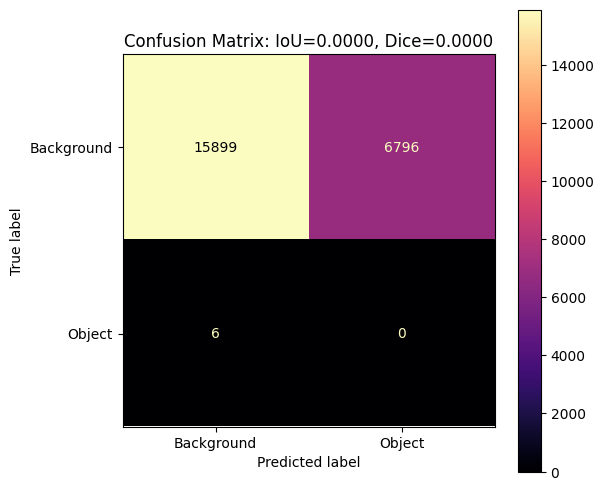

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def iou(true_mask, predicted_mask):
    intersection = np.sum(true_mask * predicted_mask)
    union = np.sum(true_mask) + np.sum(predicted_mask) - intersection
    return intersection / union

def dice_score(true_mask, predicted_mask):
    intersection = np.sum(true_mask * predicted_mask)
    return 2 * intersection / (np.sum(true_mask) + np.sum(predicted_mask))

true_mask_flat = true_mask.flatten()
predicted_mask_flat = predicted_mask.flatten()

pixel_accuracy = np.sum(true_mask_flat == predicted_mask_flat) / len(true_mask_flat)
iou_score = iou(true_mask, predicted_mask)
dice_score_value = dice_score(true_mask, predicted_mask)

cm = confusion_matrix(true_mask_flat, predicted_mask_flat, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background", "Object"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="magma", ax=ax)
plt.title(f"Confusion Matrix: IoU={iou_score:.4f}, Dice={dice_score_value:.4f}")
plt.savefig(f"{ANALYSIS}/confusion_matrix_{training_timestamp}.png")
plt.show()

# Step 13: Duplicate Notebook  

**Note:** Manually save first before duplicating the notebook.

In [ ]:
VALIDATIONS = "validations"
os.makedirs(VALIDATIONS, exist_ok=True)

filename = "ShearLineCNN.ipynb"
with open(filename, "r", encoding="utf-8") as src:
    contents = src.read()
    checkpoint = f"{VALIDATIONS}/{filename}".replace(".ipynb", f"_{training_timestamp}.ipynb")
    with open(checkpoint, "w", encoding="utf-8") as dest:
        dest.write(contents)
        print(f"Checkpoint was created at '{checkpoint}'.")

> End of code.